In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

from data import CirclesDatasetGenerator
from models.model_utils import preprocess
from data import *
import matplotlib.pyplot as plt
from itertools import product

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
dimensions = 10
samples = 100

In [275]:
class CirclesDatasetGenerator:

    def __init__(self, size=28, n_circles=1, modes=1, random_colors=True, random_sizes=True):

        self.size = size
        self.circles = n_circles
        self.has_random_colors = random_colors
        self.has_random_sizes = random_sizes
        self.modes = modes

        n_vars = n_circles * 2
        if random_colors:
            n_vars += n_circles * 3

        if random_sizes:
            n_vars += n_circles

        self.generator = MixtureDistribution('normal', 'uniform', modes, n_vars)

        self.random_color = [(np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)) for i in
                        range(n_circles)]

        self.random_size = [np.random.randint(0, round(size * 0.25)) for i in range(n_circles)]

    def generate_samples(self, n_samples):

        images = []

        samples = self.generator.generate_samples(n_samples)
        samples = (samples - np.min(samples, axis=0)) / (np.max(samples, axis=0) - np.min(samples, axis=0))

        for i in range(n_samples):

            this_image = np.ones((self.size, self.size, 3)) * 255
            for k in range(self.circles):
                sample = samples[i]

                if self.has_random_colors and self.has_random_sizes:
                    color = (
                    int(self.size * sample[6 * k + 3]), int(self.size * sample[6 * k + 4]), int(self.size * sample[6 * k + 5]))
                    circle_size = int(self.size * 0.25 * sample[6 * k + 2])
                    location = (int(self.size * sample[6 * k]), int(self.size * sample[6 * k + 1])
                    )

                elif self.has_random_sizes:
                    color = self.random_color[k]
                    circle_size = int(self.size * 0.25 * sample[3 * k + 2])
                    location = (int(self.size * sample[3 * k]), int(self.size * sample[3 * k + 1]))

                elif self.has_random_colors:
                    color = (
                    int(self.size * sample[5 * k + 2]), int(self.size * sample[5 * k + 3]), int(self.size * sample[5 * k + 4]))
                    circle_size = self.random_size[k]
                    location = (int(self.size * sample[5 * k]), int(self.size * sample[5 * k + 1])
                    )

                else:
                    color = self.random_color[k]
                    circle_size = self.random_size[k]
                    location = (int(self.size * sample[2 * k]), int(self.size * sample[2 * k + 1]))

                cv.circle(this_image, location, circle_size, color, -1)
            images.append(this_image)

        return np.array(images)/255.

    def generate_samples_to_directory(self, n_samples, output_directory):

        if output_directory:
            if not os.path.exists(output_directory):
                os.makedirs(output_directory)

        samples = self.generator.generate_samples(n_samples)
        samples = (samples - np.min(samples, axis=0)) / (np.max(samples, axis=0) - np.min(samples, axis=0))

        for i in range(n_samples):

            this_image = np.ones((self.size, self.size, 3)) * 255
            for k in range(self.circles):
                sample = samples[i]

                if self.has_random_colors and self.has_random_sizes:
                    color = (
                        int(self.size * sample[6 * k + 3]), int(self.size * sample[6 * k + 4]),
                        int(self.size * sample[6 * k + 5]))
                    circle_size = int(self.size * 0.25 * sample[6 * k + 2])
                    location = (int(self.size * sample[6 * k]), int(self.size * sample[6 * k + 1]))

                elif self.has_random_sizes:
                    color = self.random_color[k]
                    circle_size = int(self.size * 0.25 * sample[3 * k + 2])
                    location = (int(self.size * sample[3 * k]), int(self.size * sample[3 * k + 1]))

                elif self.has_random_colors:
                    color = (
                        int(self.size * sample[5 * k + 2]), int(self.size * sample[5 * k + 3]),
                        int(self.size * sample[5 * k + 4]))
                    circle_size = self.random_size[k]
                    location = (int(self.size * sample[5 * k]), int(self.size * sample[5 * k + 1]))

                else:
                    color = self.random_color[k]
                    circle_size = self.random_size[k]
                    location = (int(self.size * sample[2 * k]), int(self.size * sample[2 * k + 1]))

                cv.circle(this_image, location, circle_size, color, -1)

                cv.imwrite(os.path.join(output_directory, '%d.jpg' % (i)), this_image)

    def save_generator(self, out_file):

        with open(out_file, 'wb') as of:
            pickle.dump(self, of, pickle.HIGHEST_PROTOCOL)

In [483]:
samples, bsize = 100, 100
generator = CirclesDatasetGenerator(size=28, n_circles=1, random_colors=False, random_sizes=True, modes=2)
train_iter, val_iter, test_iter = preprocess(generator, samples, bsize)

In [484]:
# Raw output from iterators
batch, labels = next(iter(train_iter))
batch.shape

torch.Size([100, 28, 28, 3])

In [485]:
# Shape after preprocessing for input into a FFNN
batch.view(batch.shape[0], -1).shape

torch.Size([100, 2352])

In [486]:
# Shape of a single image
img = batch[0]
img.shape

torch.Size([28, 28, 3])

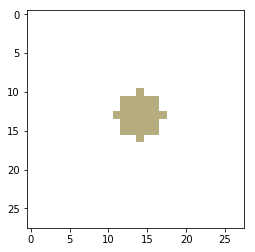

In [487]:
# Plot the image
plt.imshow(img.squeeze().numpy(), interpolation='none')

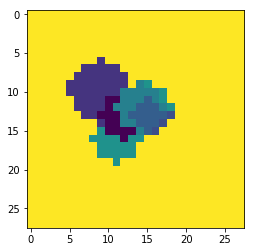

In [448]:
# Plot one channel
plt.imshow(img[:, :, 0:1].squeeze().numpy(), interpolation='none')

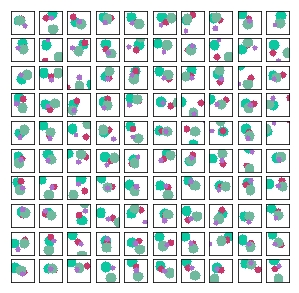

In [350]:
# Plot all images in a batch
k = 0
plt.close()
size_figure_grid = int(batch.shape[0]**0.5)
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
for i, j in product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    image = batch[k].view(28, 28, -1).squeeze().numpy()
    ax[i,j].imshow(image, interpolation='none')
    k += 1
    
plt.show()

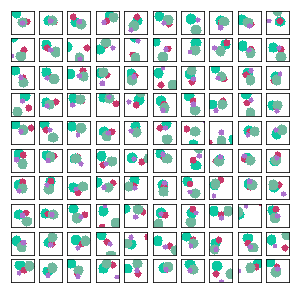

In [351]:
# Plot all images in a batch
batch, labels = next(iter(train_iter))
k = 0
plt.close()
size_figure_grid = int(batch.shape[0]**0.5)
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
for i, j in product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    image = batch[k].view(28, 28, -1).squeeze().numpy()
    ax[i,j].imshow(image, interpolation='none')
    k += 1
    
plt.show()